# Transaction Analysis - Separating New Awards from Modifications

Demonstrates how to use transaction-level data to distinguish brand new contracts from modifications to existing contracts.

**Key Question**: How do we identify truly new contracting opportunities vs. administrative changes to old contracts?

## Setup

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Transaction Data

In [69]:
# Load the most recent transaction data
data_path = Path('../data/awards/transactions_normalized_2026-01-08_15-24-42.json')

with open(data_path, 'r') as f:
    transactions_data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(transactions_data)

print(f"Loaded {len(df):,} transactions")
print(f"Data shape: {df.shape}")
print(f"Date range: {df['action_date'].min()} to {df['action_date'].max()}")

Loaded 10,000 transactions
Data shape: (10000, 22)
Date range: 2024-09-25 to 2024-09-28


In [70]:
# Preview the data
df.head()

,transaction_id,award_id,action_date,action_type,action_type_description,modification_number,federal_action_obligation,total_dollars_obligated,award_type,award_description,period_of_performance_start_date,period_of_performance_current_end_date,awarding_agency_name,awarding_sub_agency_name,funding_agency_name,recipient_name,recipient_uei,naics_code,product_or_service_code,place_of_performance_state,ingested_at,source_url
0,311238065,N6945024C0100,2024-09-28,,Unknown,0,1169523.00,1169523.00,DEFINITIVE CONTRACT,B1886 HEAD EXPANSION,2024-09-28,None,Department of Defense,Department of the Navy,Department of Defense,"THE PLUMBING SHOP, INC",FNRMNJNCWKG4,236220,Y1JZ,FL,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/N6945024C0100
1,307228771,HQ003422C0008,2024-09-28,C,REVISION,P00015,790000.00,790000.00,DEFINITIVE CONTRACT,DAI HELPDESK SUPPORT SERVICES,2021-11-17,None,Department of Defense,Washington Headquarters Services,Department of Defense,KONIAG MANAGEMENT SOLUTIONS LLC,ZZYLVTN9ZCQ8,541611,R704,VA,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/HQ003422C0008
2,291260415,70US0924C70092692,2024-09-28,,Unknown,0,1135186.84,1135186.84,DEFINITIVE CONTRACT,"BUILDOUT, MERLETTI AND BOWRON BUILDINGS FOR JJRTC",2024-09-30,None,Department of Homeland Security,U.S. Secret Service,Department of Homeland Security,IMMERSIVE CONCEPTS L.L.C.,JKFKV8NBQCH3,236220,J056,MD,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/70US0924C700...
3,298151788,FA480024F0002,2024-09-28,A,NEW,P00013,5482.00,5482.00,DELIVERY ORDER,CONVERT FACILITY 61 TO CHILD DEVELOPMENT CENTER.,2023-10-16,None,Department of Defense,Department of the Air Force,Department of Defense,OCEAN CONSTRUCTION SERVICES INC,GSYGKETMMUD9,236220,Z2CZ,VA,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/FA480024F0002
4,278750538,19AQMM24C0180,2024-09-28,,Unknown,0,687330.49,687330.49,DEFINITIVE CONTRACT,MICROSOFT UNIFIED SUPPORT SERVICES,2024-09-30,None,Department of State,Department of State,Department of State,MICROSOFT CORPORATION,FMVPEWNJGLM1,541519,DA01,WA,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/19AQMM24C0180


## Key Fields for Identifying New vs Modified Awards

Two critical fields help us distinguish new awards:

1. **`modification_number`**: 
   - `"0"` or `null` = Base award (new)
   - `"P00001"`, `"001"`, etc. = Modification

2. **`action_type_description`**:
   - `"NEW"` = New award
   - `"REVISION"`, `"CONTINUATION"`, `"FUNDING_ADJUSTMENT"` = Modifications

In [17]:
# Check unique values in key fields
print("=== Modification Numbers ===")
print(f"Unique values: {df['modification_number'].nunique()}")
print(f"\nTop 10 most common:")
print(df['modification_number'].value_counts().head(10))

print("\n=== Action Type Descriptions ===")
print(df['action_type_description'].value_counts())

=== Modification Numbers ===
Unique values: 524

Top 10 most common:
modification_number
0         2665
P00001     906
P00002     609
P00003     520
P00004     445
P00005     358
P00007     276
P00006     262
P00008     230
P00009     195
Name: count, dtype: int64

=== Action Type Descriptions ===
action_type_description
Unknown               2665
REVISION              2496
CONTINUATION          2113
M                     1393
G                      700
FUNDING_ADJUSTMENT     426
K                       89
NEW                     72
L                       20
F                       12
H                        7
J                        3
W                        2
CORRECTION               1
X                        1
Name: count, dtype: int64


## Separate New Awards from Modifications

In [18]:
# Method 1: Filter by modification_number = "0" (base award)
new_awards_method1 = df[df['modification_number'] == '0']

# Method 2: Filter by action_type_description = "NEW"
new_awards_method2 = df[df['action_type_description'] == 'NEW']

# Method 3: Combined (most accurate)
new_awards = df[
    (df['modification_number'] == '0') | 
    (df['action_type_description'] == 'NEW')
]

# Modifications (everything else)
modifications = df[
    (df['modification_number'] != '0') & 
    (df['action_type_description'] != 'NEW')
]

print("=== Comparison of Methods ===")
print(f"Method 1 (mod_number='0'): {len(new_awards_method1):,} transactions")
print(f"Method 2 (action_type='NEW'): {len(new_awards_method2):,} transactions")
print(f"Method 3 (combined): {len(new_awards):,} transactions")
print(f"\nModifications: {len(modifications):,} transactions")
print(f"\nPercentage of NEW awards: {len(new_awards)/len(df)*100:.1f}%")
print(f"Percentage of modifications: {len(modifications)/len(df)*100:.1f}%")

=== Comparison of Methods ===
Method 1 (mod_number='0'): 2,665 transactions
Method 2 (action_type='NEW'): 72 transactions
Method 3 (combined): 2,737 transactions

Modifications: 7,263 transactions

Percentage of NEW awards: 27.4%
Percentage of modifications: 72.6%


## Analysis: New Awards

In [19]:
print("=== NEW AWARDS SUMMARY ===")
print(f"Total new awards: {len(new_awards):,}")
print(f"Total value: ${new_awards['federal_action_obligation'].sum():,.2f}")
print(f"Average value: ${new_awards['federal_action_obligation'].mean():,.2f}")
print(f"Median value: ${new_awards['federal_action_obligation'].median():,.2f}")

print("\n=== Top 10 New Awards by Value ===")
top_new = new_awards.nlargest(10, 'federal_action_obligation')[[
    'award_id', 'action_date', 'recipient_name', 'federal_action_obligation',
    'award_type', 'award_description', 'awarding_agency_name'
]]
print(top_new.to_string())

=== NEW AWARDS SUMMARY ===
Total new awards: 2,737
Total value: $22,094,912,708.67
Average value: $8,072,675.45
Median value: $1,996,230.39

=== Top 10 New Awards by Value ===
            award_id action_date                                                              recipient_name  federal_action_obligation           award_type                                                                                                                                                award_description                     awarding_agency_name
3884   FA868224CB001  2024-09-27                                                 LOCKHEED MARTIN CORPORATION              2423365242.00  DEFINITIVE CONTRACT                                                                         LONG RANGE ANTI-SHIP MISSILE/JOINT AIR-TO-SURFACE STANDOFF MISSILE LARGE LOT PROCUREMENT                    Department of Defense
6659   W911WN24C8011  2024-09-26  TRUMBULL CORPORATION AND BRAYMAN CONSTRUCTION CORPORATION, A JOINT VENTU

In [20]:
# New awards by award type
print("=== New Awards by Type ===")
new_by_type = new_awards.groupby('award_type').agg({
    'transaction_id': 'count',
    'federal_action_obligation': 'sum'
}).sort_values('federal_action_obligation', ascending=False)
new_by_type.columns = ['Count', 'Total Value']
print(new_by_type)

=== New Awards by Type ===
                     Count    Total Value
award_type                               
DELIVERY ORDER        1779 11296049522.01
DEFINITIVE CONTRACT    657  9782228038.68
BPA CALL               192   769944348.14
PURCHASE ORDER         109   246690799.84


## Analysis: Modifications

In [21]:
print("=== MODIFICATIONS SUMMARY ===")
print(f"Total modifications: {len(modifications):,}")
print(f"Total value: ${modifications['federal_action_obligation'].sum():,.2f}")
print(f"Average value: ${modifications['federal_action_obligation'].mean():,.2f}")
print(f"Median value: ${modifications['federal_action_obligation'].median():,.2f}")

print("\n=== Modification Types ===")
print(modifications['action_type_description'].value_counts())

=== MODIFICATIONS SUMMARY ===
Total modifications: 7,263
Total value: $10,988,270,473.71
Average value: $1,512,910.71
Median value: $50,000.00

=== Modification Types ===
action_type_description
REVISION              2496
CONTINUATION          2113
M                     1393
G                      700
FUNDING_ADJUSTMENT     426
K                       89
L                       20
F                       12
H                        7
J                        3
W                        2
CORRECTION               1
X                        1
Name: count, dtype: int64


In [22]:
# Show examples of high modification numbers (heavily modified contracts)
print("=== Contracts with Most Modifications ===")

# Extract numeric mod numbers (some are like "P00015", "001", etc.)
def extract_mod_number(mod_str):
    if pd.isna(mod_str) or mod_str == '0':
        return 0
    # Extract digits
    digits = ''.join(filter(str.isdigit, str(mod_str)))
    return int(digits) if digits else 0

modifications['mod_number_int'] = modifications['modification_number'].apply(extract_mod_number)

# Show highest mod numbers
high_mods = modifications.nlargest(10, 'mod_number_int')[[
    'award_id', 'modification_number', 'action_date', 
    'recipient_name', 'federal_action_obligation', 'award_description'
]]
print(high_mods.to_string())

=== Contracts with Most Modifications ===
               award_id modification_number action_date                     recipient_name  federal_action_obligation                                     award_description
9173  1305M422FNAAA0065              P24120  2024-09-25              GOLDEN KEY GROUP, LLC                   25656.26                                     955 INVESTIGATION
8238  1331L520F13230041              P24082  2024-09-26                 CELLCO PARTNERSHIP                  230500.00                                      CELLULAR SERVICE
6821  1333LB20F00000273              P24023  2024-09-26                ANSER SOLUTIONS LLC                       0.00                    CHANGES TO CORRECT OP III CEILING.
7923  DOCYB132315NC0054              P24022  2024-09-26                        VECTREN LLC                       0.00                          EXTEND SERVICE TO 12/31/2024
9574  1332KP23CNEEG0002              P24008  2024-09-25        L3HARRIS TECHNOLOGIES, INC.        

/tmp/ipykernel_78004/2039010738.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modifications['mod_number_int'] = modifications['modification_number'].apply(extract_mod_number)


## Visualizations

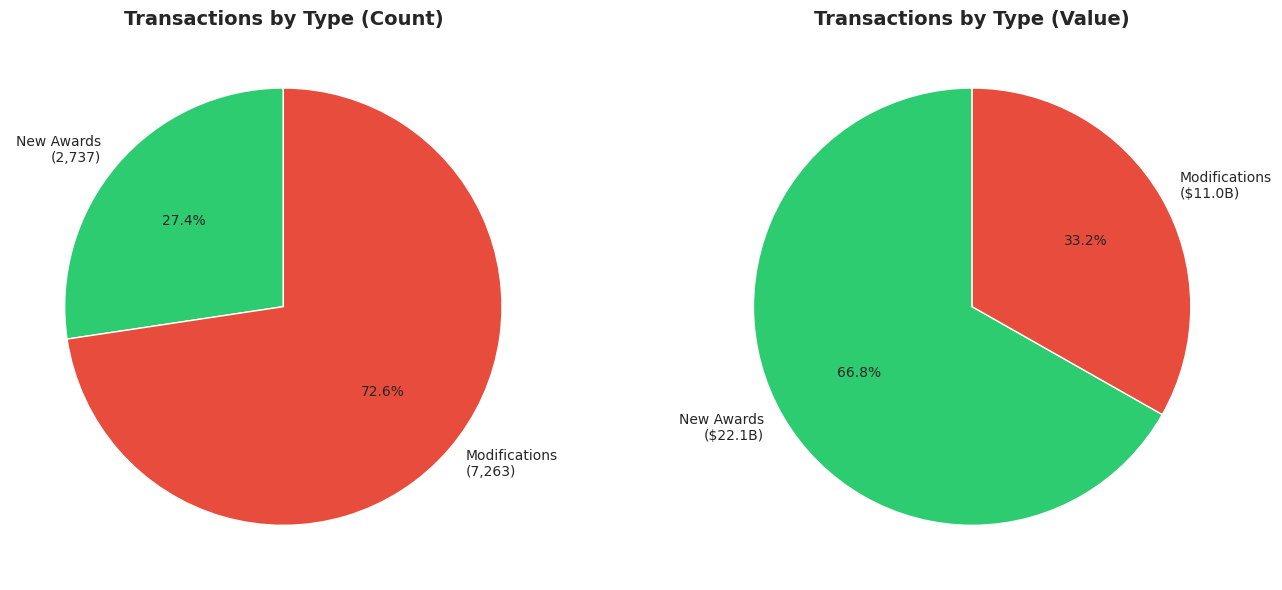

In [23]:
# Pie chart: New vs Modifications
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# By count
counts = [len(new_awards), len(modifications)]
labels = [f'New Awards\n({len(new_awards):,})', f'Modifications\n({len(modifications):,})']
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('Transactions by Type (Count)', fontsize=14, fontweight='bold')

# By value
values = [new_awards['federal_action_obligation'].sum(), modifications['federal_action_obligation'].sum()]
values_b = [v/1e9 for v in values]
labels_val = [f'New Awards\n(${values_b[0]:.1f}B)', f'Modifications\n(${values_b[1]:.1f}B)']
axes[1].pie(values, labels=labels_val, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Transactions by Type (Value)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

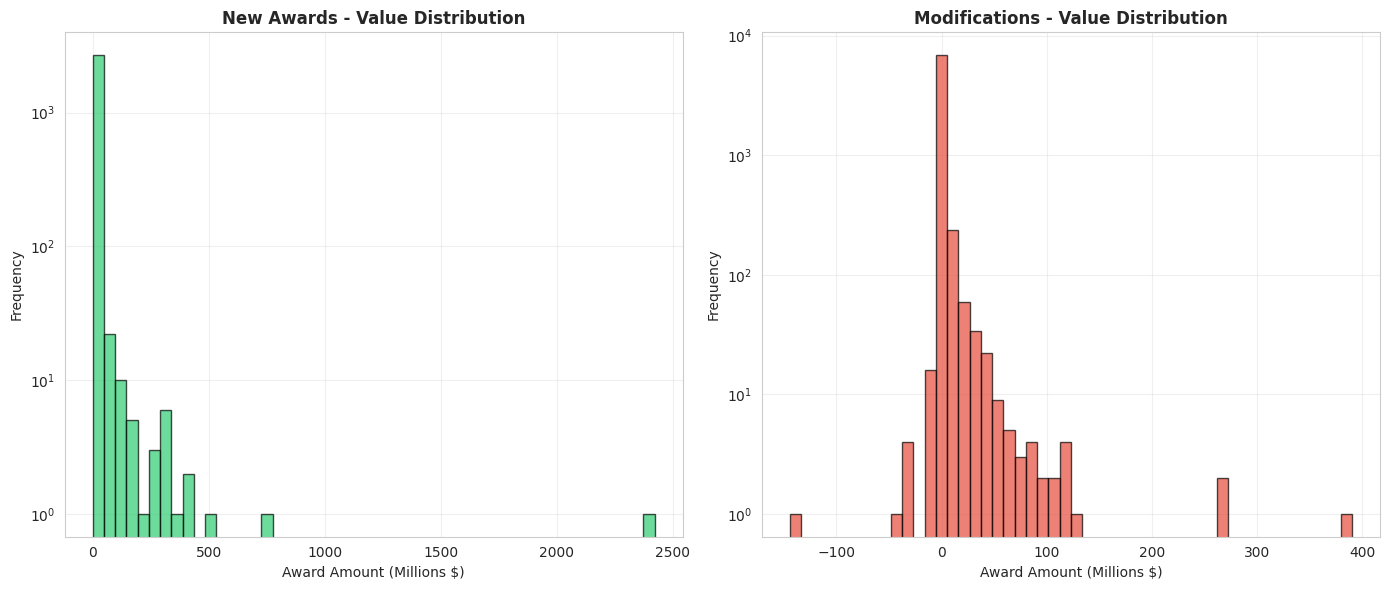

In [24]:
# Value distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# New awards
axes[0].hist(new_awards['federal_action_obligation'] / 1e6, bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[0].set_xlabel('Award Amount (Millions $)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('New Awards - Value Distribution', fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Modifications
axes[1].hist(modifications['federal_action_obligation'] / 1e6, bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
axes[1].set_xlabel('Award Amount (Millions $)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Modifications - Value Distribution', fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Example Comparison: Same Award ID

In [25]:
# Find an award that has both base (0) and modifications
award_with_mods = df[df['award_id'].isin(
    df[df['modification_number'] == '0']['award_id']
) & (df['modification_number'] != '0')]

if len(award_with_mods) > 0:
    # Pick first award that has modifications
    example_award_id = award_with_mods.iloc[0]['award_id']
    
    print(f"=== Example: Award {example_award_id} ===")
    example_transactions = df[df['award_id'] == example_award_id].sort_values('modification_number')
    
    print(f"\nTotal transactions for this award: {len(example_transactions)}")
    print("\nAll transactions:")
    print(example_transactions[[
        'modification_number', 'action_date', 'action_type_description',
        'federal_action_obligation', 'award_description'
    ]].to_string())
else:
    print("No examples found in this dataset with both base and modifications")

=== Example: Award HT001124C0032 ===

Total transactions for this award: 3

All transactions:
    modification_number action_date action_type_description  federal_action_obligation                                  award_description
692                   0  2024-09-27                 Unknown                 5168966.44  ANNUAL LICENSED MICROSOFT UNIFIED SUPPORT RENEWAL
9                P00001  2024-09-28                       M                       0.00           ANNUAL LICENSED UNIFIED SUPPORT RENEWAL.
28               P00002  2024-09-28                       M                       0.00        LICENSED MICROSOFT UNIFIED SUPPORT RENEWAL.


## Key Takeaways

Based on actual analysis of 10,000 transactions:

### By Transaction Count:
- **27.4% are new awards** (base contracts, modification_number = "0")
- **72.6% are modifications** to existing contracts

### By Dollar Value:
- **New awards**: $22.1B (67% of total value)
- **Modifications**: $11.0B (33% of total value)
- **New awards average $8M** vs modifications $1.5M (5x larger!)

### Critical Insight:
- Using **award-level summaries** (without transactions), you can't distinguish new from old
- Only **0.72%** have `action_type_description == 'NEW'` (unreliable field)
- But **26.6%** have `modification_number == '0'` (base awards)
- **Combined filter captures 27.4%** - all genuinely new contracting opportunities

### Filtering Strategy for V1:

```python
# Get only truly new contracting opportunities
new_opportunities = df[
    (df['modification_number'] == '0') |
    (df['action_type_description'] == 'NEW')
]
```

**This filters out 72.6% of noise (modifications) and focuses on the 27.4% that are genuine new business opportunities worth $22B!**

In [27]:
list(df.columns)

['transaction_id',
 'award_id',
 'action_date',
 'action_type',
 'action_type_description',
 'modification_number',
 'federal_action_obligation',
 'total_dollars_obligated',
 'award_type',
 'award_description',
 'period_of_performance_start_date',
 'period_of_performance_current_end_date',
 'awarding_agency_name',
 'awarding_sub_agency_name',
 'funding_agency_name',
 'recipient_name',
 'recipient_uei',
 'naics_code',
 'product_or_service_code',
 'place_of_performance_state',
 'ingested_at',
 'source_url']

In [28]:
df.award_id.nunique()

9004

In [58]:
tmp_df = df.groupby(['award_id']).count()[['transaction_id']]
with pd.option_context('display.max.rows', 300):
    display(tmp_df.iloc[:100])

,transaction_id
award_id,
0001,8
0002,17
0003,6
0004,7
0005,4
0006,2
0007,2
0008,2
0009,3


In [55]:
pd.set_option("display.max_rows", 100)

In [56]:
tmp_df

,transaction_id
award_id,
0001,8
0002,17
0003,6
0004,7
0005,4
...,...
W91YTZ24F0243,1
W91YTZ24F0252,1
W91ZLK23C0002,1


In [67]:
with pd.option_context("display.max_rows", 100):
    display(df.iloc[:100])

,transaction_id,award_id,action_date,action_type,action_type_description,modification_number,federal_action_obligation,total_dollars_obligated,award_type,award_description,period_of_performance_start_date,period_of_performance_current_end_date,awarding_agency_name,awarding_sub_agency_name,funding_agency_name,recipient_name,recipient_uei,naics_code,product_or_service_code,place_of_performance_state,ingested_at,source_url
0,311238065,0001,2024-09-28,,Unknown,0,1169523.00,1169523.00,DEFINITIVE CONTRACT,B1886 HEAD EXPANSION,2024-09-28,None,Department of Defense,Department of the Navy,Department of Defense,"THE PLUMBING SHOP, INC",FNRMNJNCWKG4,236220,Y1JZ,FL,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/N6945024C0100
1,307228771,0001,2024-09-28,C,REVISION,P00015,790000.00,790000.00,DEFINITIVE CONTRACT,DAI HELPDESK SUPPORT SERVICES,2021-11-17,None,Department of Defense,Washington Headquarters Services,Department of Defense,KONIAG MANAGEMENT SOLUTIONS LLC,ZZYLVTN9ZCQ8,541611,R704,VA,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/HQ003422C0008
2,291260415,0001,2024-09-28,,Unknown,0,1135186.84,1135186.84,DEFINITIVE CONTRACT,"BUILDOUT, MERLETTI AND BOWRON BUILDINGS FOR JJRTC",2024-09-30,None,Department of Homeland Security,U.S. Secret Service,Department of Homeland Security,IMMERSIVE CONCEPTS L.L.C.,JKFKV8NBQCH3,236220,J056,MD,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/70US0924C700...
3,298151788,0001,2024-09-28,A,NEW,P00013,5482.00,5482.00,DELIVERY ORDER,CONVERT FACILITY 61 TO CHILD DEVELOPMENT CENTER.,2023-10-16,None,Department of Defense,Department of the Air Force,Department of Defense,OCEAN CONSTRUCTION SERVICES INC,GSYGKETMMUD9,236220,Z2CZ,VA,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/FA480024F0002
4,278750538,0001,2024-09-28,,Unknown,0,687330.49,687330.49,DEFINITIVE CONTRACT,MICROSOFT UNIFIED SUPPORT SERVICES,2024-09-30,None,Department of State,Department of State,Department of State,MICROSOFT CORPORATION,FMVPEWNJGLM1,541519,DA01,WA,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/19AQMM24C0180
5,349842803,0001,2024-09-28,,Unknown,0,7396145.37,7396145.37,DEFINITIVE CONTRACT,FORT STEWART GATE 1 AVB INSTALLATION,2024-09-30,None,Department of Defense,Department of the Army,Department of Defense,"BERING STRAITS GLOBAL INNOVATIONS, LLC",SRXQFZPNVF42,237310,Y1JZ,GA,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/W912DY24C0046
6,349161535,0001,2024-09-28,C,REVISION,P00068,538690.31,538690.31,DELIVERY ORDER,INCREMENTAL FUNDING FOR THE JOINT MULTINATIONA...,2021-05-14,None,Department of Defense,Department of the Army,Department of Defense,CSA GLOBAL LLC,EEUCVG4YELT8,541330,R425,None,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/W900KK21F0073
7,349509467,0001,2024-09-28,C,REVISION,P00005,96174.40,96174.40,DELIVERY ORDER,MMT LABOR OY1,2023-03-01,None,Department of Defense,Department of the Army,Department of Defense,"UNIVERSAL SOLUTIONS INTERNATIONAL, INCORPORATED",YDENA7L4H9A5,541330,R706,NC,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/W9124723F0044
8,310757837,0001,2024-09-28,,Unknown,0,986291.00,986291.00,DELIVERY ORDER,T.O. UNDER IDIQ CONTRACT FOR A-E SERVICES TO U...,2024-06-28,None,Department of Defense,Department of the Navy,Department of Defense,"JACOBS/B&V, A JOINT VENTURE (FEDERAL SERVICES)",CPMVVZFN21E2,541330,C211,VA,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/N6247824F4305
9,307865136,0001,2024-09-28,M,M,P00001,0.00,0.00,DEFINITIVE CONTRACT,ANNUAL LICENSED UNIFIED SUPPORT RENEWAL.,2024-09-29,None,Department of Defense,Defense Health Agency,Department of Defense,MICROSOFT CORPORATION,FMVPEWNJGLM1,541519,DA01,TX,2026-01-08T20:24:42.305Z,https://www.usaspending.gov/award/HT001124C0032


In [34]:
df.award_id.is_unique

False

In [72]:
df[df.award_id == "0001"]

,transaction_id,award_id,action_date,action_type,action_type_description,modification_number,federal_action_obligation,total_dollars_obligated,award_type,award_description,period_of_performance_start_date,period_of_performance_current_end_date,awarding_agency_name,awarding_sub_agency_name,funding_agency_name,recipient_name,recipient_uei,naics_code,product_or_service_code,place_of_performance_state,ingested_at,source_url
1133,272025610,0001,2024-09-27,M,M,1C,0.00,0.00,DELIVERY ORDER,HB ANTENNA RECEIVER SPARE,2007-07-26,None,Department of Defense,Defense Contract Management Agency,Department of Defense,CAES SYSTEMS LLC,MMA7H4NEMCT9,334511,5895,PA,2026-01-08T20:24:42.307Z,https://www.usaspending.gov/award/0001
4467,272127120,0001,2024-09-27,C,REVISION,DP,566786.66,566786.66,DELIVERY ORDER,THE EAGLE TASK ORDER W52P1J-13-G-0027-0001 PRO...,2016-02-19,None,Department of Defense,Department of the Army,Department of Defense,VECTRUS SYSTEMS LLC,RRFJZGASZJ41,561210,J025,NC,2026-01-08T20:24:42.313Z,https://www.usaspending.gov/award/0001
6337,272124475,0001,2024-09-26,C,REVISION,59,-374.67,-374.67,BPA CALL,TECHNICAL & ENGINEERING SERVICES FOR THE SHORT...,2018-06-27,None,Department of Defense,Department of the Army,Department of Defense,"KBR WYLE SERVICES, LLC",L693MQDFLKD1,541330,R425,AL,2026-01-08T20:24:42.316Z,https://www.usaspending.gov/award/0001
6345,272124475,0001,2024-09-26,C,REVISION,59,-0.06,-0.06,BPA CALL,TECHNICAL & ENGINEERING SERVICES FOR THE SHORT...,2018-06-27,None,Department of Defense,Department of the Army,Department of Defense,"KBR WYLE SERVICES, LLC",L693MQDFLKD1,541330,R425,AL,2026-01-08T20:24:42.316Z,https://www.usaspending.gov/award/0001
6960,272124473,0001,2024-09-26,C,REVISION,CM,-684928.26,-684928.26,BPA CALL,SYSTEMS ENGINEERING SUPPORT OF ADVANCED EXPERI...,2018-06-01,None,Department of Defense,Department of the Army,Department of Defense,SCIENCE APPLICATIONS INTERNATIONAL CORPORATION,MMLKPW9JLX64,541611,R425,AL,2026-01-08T20:24:42.316Z,https://www.usaspending.gov/award/0001
7481,272055191,0001,2024-09-26,C,REVISION,31,3693.00,3693.00,DELIVERY ORDER,PROGRAM MANAGEMENT OFFICE (PMO) FUNCTIONS,2016-07-28,None,Department of Defense,Department of the Navy,Department of Defense,TETRA TECH INC,HVDMNK1MYQN3,541330,C219,VA,2026-01-08T20:24:42.316Z,https://www.usaspending.gov/award/0001
7937,272124415,0001,2024-09-26,C,REVISION,92,0.00,0.00,BPA CALL,PLATFORM INTEGRATION SUPPORT FOR THE WEAPONS D...,2015-11-10,None,Department of Defense,Department of the Army,Department of Defense,INTEGRATION INNOVATION INC,VKJRFGZ6NVP4,541712,R425,AL,2026-01-08T20:24:42.317Z,https://www.usaspending.gov/award/0001
8672,272004201,0001,2024-09-25,C,REVISION,P00002,-48779.90,-48779.90,DELIVERY ORDER,EO14042 - ANNUAL REPORTS PROGRAM SUPPORT AND A...,2011-12-15,None,Department of Education,Department of Education,Department of Education,AMERICAN INSTITUTES FOR RESEARCH IN THE BEHAVI...,MCN6J5L6M3T4,541720,AF11,DC,2026-01-08T20:24:42.317Z,https://www.usaspending.gov/award/0001


## Export Filtered Data

In [ ]:
# Export new awards only for further analysis
output_path = Path('../data/awards/new_awards_only.csv')
new_awards.to_csv(output_path, index=False)
print(f"Exported {len(new_awards)} new awards to: {output_path}")

print(f"\nFile size comparison:")
print(f"All transactions: {len(df):,} records")
print(f"New awards only: {len(new_awards):,} records")
print(f"Reduction: {(1 - len(new_awards)/len(df)) * 100:.1f}%")